# Across-Subject Testing with [glhmm toolbox](https://github.com/vidaurre/glhmm)
This tutorial demonstrates how apply ```across-subject``` testing using the [glhmm toolbox](https://github.com/vidaurre/glhmm). 
We will use data sourced from the Human Connectome Project (HCP) S1200 Young Adult dataset ([van Essen et al., 2013]((https://pubmed.ncbi.nlm.nih.gov/23684880/))).\

**NOTE: Running this tutorial requires the HCP data. Make sure you have been granted permission to use the HCP data. If not, apply for such permission to get the HCP data by following the instructions [here](https://db.humanconnectome.org/).**

 The HCP dataset provides an real-world context for this analysis and offers detailed information for each subject. ```Testing_across_subjects``` involves evaluating the relationship between one or more HMM-related aggregated statistics and behavioral traits, such as sex and age or individual traits.

We'll set up HMM-related aggregated statistics as the independent variable (```D```) and behavioral traits as the dependent variable (```R```). The goal is to assess the relationship between these variables.

Throughout the tutorial, we'll guide you on applying the [glhmm toolbox](https://github.com/vidaurre/glhmm) and drawing conclusions from the HCP dataset. While the setup of the glhmm toolbox may require some explanation, running the test itself is straightforward—simply input the variables ```D``` and ```R```, and define the specific ```method``` you wish to apply. In this case, the methods include permutation using regression or permutation using correlation and is described in the paper [Vidaurre et al. 2023](https://arxiv.org/abs/2312.07151#:~:text=GLHMM%20is%20implemented%20as%20a,sets%20at%20reasonable%20computational%20time).




## Table of Contents
1. [Load and prepare data](#load-data)
    * [HMM-aggregated statistics](#HMM-agg)
2. [Across-Subjects testing](#across_subjects)
    * [Family structure](#fam-struc)
    * [Across subjects - Regression](#perm-regression)
    * [Across subjects - Correlation](#perm-correlation)


### Install necessary packages
If you dont have the **GLHMM-package** installed, then run the following command in your terminal:

```pip install glhmm```

To use the function ```glhmm.statistics.py``` you also need to install the library's:
```
pip install statsmodels
``` 
```
pip install tqdm
```
``` 
pip install -U scikit-image
``` 

``` 

### Import libraries
Let's start by importing the required libraries and modules.

In [1]:
import os
import numpy as np
import pandas as pd
from glhmm import glhmm, graphics, statistics, io

## 1. Load and prepare data <a id="load-data"></a>
For reproducibility and since the HCP dataset is very large, we provide the ```Gamma``` values (state probabilities at each timepoint) from a pre-trained HMM. If you don't have these values, you can follow the instructions to train a standard HMM model in this [tutorial](https://github.com/vidaurre/glhmm/blob/main/docs/notebooks/GaussianHMM_example.ipynb) from the [glhmm toolbox](https://github.com/vidaurre/glhmm).


**Load Data**
Let's start by loading the essential data for this tutorial:
* ```Gamma```: State probabilities at each timepoint exported from a fitted HMM model. The model is trained on HCP rest fMRI timeseries from 1001 subjects in the groupICA50 parcellation.
* ```data_behavioral```: Behavioral and demographic items from the same 1001 HCP subjects.



In [2]:
# Define the folder and file names
folder_name = "data"
data_behavioral_file = 'data_behavioral.npy'
data_gamma_file = 'gamma.npy'

# Load behavioral data
file_path = os.path.join(folder_name, data_behavioral_file)
data_behavioral = np.load(file_path)

# Load gamma data
file_path = os.path.join(folder_name, data_gamma_file)
data_gamma = np.load(file_path)

**Explore data**\
Let's take a closer look at the structure of the data.

In [3]:
print(f"Data dimension of data_behavioral: {data_behavioral.shape}")
print(f"Data dimension of data_gamma: {data_gamma.shape}")

Data dimension of data_behavioral: (1001, 2)
Data dimension of data_gamma: (4804800, 6)


The behavioral measurements, denoted as ```data_behavioral``` =[1001, 2], reveals that we have measurements for 1001 subjects. Each subject include information about their 'sex' and 'age'.

Looking at ```data_gamma``` =[4804800, 6], we find that gamma measurements are concatenated for every timepoint across subjects (4804800 in total, corresponding to 1001 subjects by 4800 timepoints). The dataset comprises 6 columns, each representing the 6 different states at each timepoint per subject. 


### HMM-aggregated statistics <a id="HMM-agg"></a>

The purpose of the ```test_across_subjects``` function is to conduct permutation tests between subjects. Like mentioned earlier, the ```data_gamma``` is a concatenated dataset across subjects and timepoints, totaling 4804800 data points (1001 subjects by 4800 time points) with 6 columns representing different states at each timepoint per subject.

To perform permutation testing using the ```test_across_subjects``` function, we first need to compute HMM-related aggregated statistics. This involves deriving values that condense the states of the entire time series for each subject, resulting in a single set of values per subject (one row of data).\
Since we have gamma output from the HMM (model trained in [Prediction tutorial](./Prediction_example.ipynb)), we can calculate the Fractional Occupancy (FO). FO measures the duration spent in each state, providing the probability distribution for each state across the entire time series. As a result, each subject ends up with a single set of values that represents the states into a probability distribution that sums up to one for each subject.

**Calculate indices**\
To calculate the ```FO``` from the gamma values, we must first specify the indices in the concatenated timeseries that correspond to the beginning and end of individual subjects or sessions. These indices should be organized in the shape of [n_subjects, 2] to precisely delineate subject boundaries within the concatenated timeseries.



To achieve this, we'll use the function ```get_timestamp_indices```. By providing the number of time points (1200) and the number of subjects (1001), the function outputs a variable in the shape of (n_subjects, 2). This variable contains the indices for the beginning and end of each subject's scanning session.




In [4]:
# Prepare the number of time points and number of subjects
n_timepoints = 4800
n_subjects = 1001
idx_time = statistics.get_indices_timestamp(n_timepoints, n_subjects)

Let's visualize the the first 5 time points

In [5]:
# Visualize the first 5 timepoints
idx_time[:5]

array([[    0,  4800],
       [ 4800,  9600],
       [ 9600, 14400],
       [14400, 19200],
       [19200, 24000]])

**Calculate Fractional Occupancy (FO)**
Having obtained the necessary indices (```idx_time```), we can now proceed to calculate the FO using the [glhmm toolbox](https://github.com/vidaurre/glhmm).

In [6]:
# Calculate FO
FO = glhmm.utils.get_FO(data_gamma, idx_time)

Let's take a closer look at the structure of FO and the behavioral data.

In [7]:
print(f"Data dimension of FO: {FO.shape}")
print(f"Data dimension of data_behavioral: {data_behavioral.shape}")

Data dimension of FO: (1001, 6)
Data dimension of data_behavioral: (1001, 2)


In this example, (```FO```) is a 1001x6 matrix and represent the distribution of the duration spent in different states across 1001 subjects. Each row of the matrix corresponds to a subject, and each column represents a specific state.

For example, if the FO matrix entry ```FO[i, j]``` is 0.2, it suggests that, on average, subject ```i``` spends 20% of the time in state ```j```. These fractional occupancies provide insights into the temporal dynamics of the underlying states of the system across a population of subjects. It makes it possible to runderstand how subjects transition between different states and the overall patterns of behavior within each state.

Now, both ```FO``` and ```data_behavioral``` share the same number (N) of observations, aligning with the total number of subjects. As mentioned in the paper, the testing procedure involves a (N-by-p) design matrix, denoted as D, where p signifies the number of predictors. In our case, ```FO``` serves as the independent variable. 
Additionally, we have a matrix R with dimensions (N-by-q), representing dependent variables. In our context, ```data_behavioral``` fulfills the role of the dependent variable. Here, q signifies the number of outcomes to be tested.

Following this setup ensures a consistent and accurate testing process across our dataset.

## 2. Across-subjects testing <a id="across_subjects"></a>
As we transition to the next phase of this tutorial, we will learn how to apply the ```across_subjects``` function to uncover relationships between the ```FO``` (D) and the corresponding ```behavioral variables``` (R) using permutation testing. 

**Permutation testing**\
 Permutation testing is a non-parametric resampling technique that assesses statistical significance without assuming any data distribution. By randomly reshuffling measured data, it generates a null distribution, which can be used to test the null hypothesis—there is no difference or relationship between variables of interest to be tested. For the ```across_subject``` test it implies that each observation represents an individual subject, so we can shuffle or rearrange across subjects, as depicted in Figure 5A in the [paper](https://www.biorxiv.org/content/10.1101/2023.01.03.522583v4).


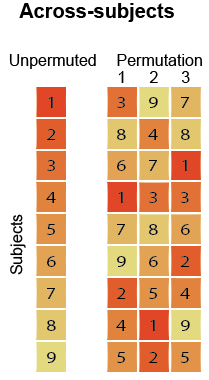

 **Figure 5A**: A 9 x 4 matrix representing permutation testing across subjects. Each row corresponds to a subject, with one observation each. The first column: displays the original index of each subject (perm=0). Next columns: examples of permuted subject indices.



### Family structure <a id="fam-struc"></a>
By default, the ```test_across_subjects``` function assumes exchangeability across all subjects, meaning any pair of subjects can be swapped. However, in reality, familial connections between subjects may exist and can therefore violate the assumption that each subject are independent from each other. 

To accommodate these connections, permutation tests with HCP data—or any dataset—involve creating the ```EB.csv``` file (Exchangeability Block). This file organizes data into blocks, each representing a family and makes it possibole to perform collective shuffling of entire families. For a more detailed explanation, refer to ([Winkler et al, 2015](https://www.sciencedirect.com/science/article/pii/S105381191500508X?via%3Dihub)). A tutorial on creating your ```EB.csv``` from the HCP dataset can be found in the notebook [HCP_multi_level_block_permutation.ipynb](https://github.com/vidaurre/glhmm/blob/main/docs/notebooks/multi_level_block_permutation_tutorial.ipynb)

When using the ```test_across_subjects``` function to consider family structure, you input a dictionary and we call it ```dict_fam```. This dictionary specifies the directory to load the ```EB.csv``` file and includes optional parameters for running the permutation. In our example, we'll use default options and define the file location of the family structure data (```EB.csv```).

In [8]:
dict_fam = {
    'file_location': 'EB.csv',  # Specify the file location of the family structure data
    # 'file_location': r'C:\Users\...\EB.csv'
}

### Across subjects - Regression <a id="perm-regression"></a>
In regression analysis, we are trying to explain the relationships between predictor variables (```D_data```) the response variable or signal (```R_data```).

**Understanding Regression:**\
The objective is to uncover the factors influencing changes in our behavioral measurements. Specifically, we examine the amount of explained variance, it can be used to analyze whether the ```FO```— representing the distribution of the duration spent in different states— significantly contributes to explaining the observed variability in behavioral measurements like 'sex' or 'age.'
A significant result indicates that certain patterns in ```FO``` significantly contribute to explaining why the behavioral measurements varies. A non-significant result, on the other hand, suggests that the observed relationship can be attributed to random chance, implying that the ```FO``` may not play a significant role in accounting for the variability of the behavioral measurements ('sex', 'age').

**Run the ```test_across_subjects``` function**:\
To run the ```test_across_subjects``` function requires providing inputs of ```FO``` (D) and ```data_behavioral``` (R). Sense we take family structure into account we will also include the variable ```dict_fam``` as an input.  Additionally, you can account for potential confounding variables by regressing them out through permutation testing.
To initiate regression-based permutation testing, set ```method="regression"```.

In this example, we will test how ```FO``` relate to variations in 'sex' and 'age'.

In [9]:
# Set the parameters for between-subject testing
method = "regression"
Nperm = 1000 # Number of permutations (default = 0)
test_statistic_options = True
# Perform across-subject testing
result_regression  =statistics.test_across_subjects(FO, data_behavioral, method=method,Nperm=Nperm, 
                                                    dict_family=dict_fam, test_statistics_option=True)

Number of possible permutations is exp(1586.6248450207656).
Generating 1000 shufflings (permutations only).


100%|██████████| 1000/1000 [00:00<00:00, 4797.40it/s]


We can now examine the local ```result_regression``` variable.

In [10]:
result_regression

{'pval': array([0.000999  , 0.01898102]),
 'base_statistics': array([0.04184935, 0.01627016]),
 'test_statistics': array([[0.04184935, 0.01627016],
        [0.00436201, 0.01452924],
        [0.00407585, 0.00493175],
        ...,
        [0.01040707, 0.00430316],
        [0.0105369 , 0.00139424],
        [0.00217056, 0.01840558]]),
 'test_type': 'test_across_subjects',
 'method': 'regression',
 'test_combination': False,
 'max_correction': False,
 'performed_tests': {'t_test_cols': [], 'f_test_cols': []},
 'Nperm': 1000}

What we can see here is that ```result_regression``` is a dictionary containing the outcomes of a statistical analysis conducted using the specified ```method``` and ```test_type```. 

Let us break it down:
* ```pval```: This array holds the p-values resulting from the permutation test. Each value corresponds to a behavioral variable and will have shape of 1 by q, see [paper](https://www.biorxiv.org/content/10.1101/2023.01.03.522583v4).

* ```base_statistics```: Stores the base statistics of the tests. In this case it is the explained variance $R^2$

* ```test_statistic```: Will by default always return a list of the base (unpermuted) statistics when ```test_statistic_option=False```. This list can store the test statistics associated with the permutation test. It provides information about the permutation distribution that is used to calculate the p-values. The output will exported if we set ```test_statistic_option=True```

* ```test_type```: Indicates the type of permutation test performed. In this case, it is ```across_subjects```.

* ```method```: Specifies the analytical method employed, which is ```'regression'```, which means that the analysis is carried out using regression-based permutation testing.

* ```test_combination``` Specifies if calculates geometric means of p-values using permutation testing has been performed.

* ```max_correction```: Boolean value that indicates whether Max correction has been applied when performing permutation testing

* ```performed_tests```: A dictionary that marks the columns in the test_statistics or p-value matrix corresponding to the (q dimension) where t-tests or F-tests have been performed.

* ```Nperm```: Is the number of permutations that has been performed.


**Visualization of results**\
Now that we have performed our test, we can then visualize the p-value array.\
We will import the function ```plot_heatmap``` from module ```helperfunctions.py```

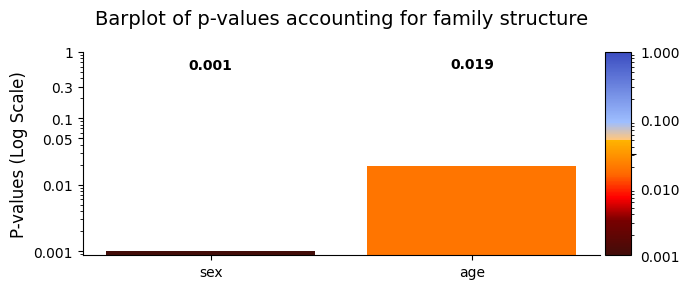

In [11]:
# Plot p-values
xticklabels=["sex","age"] 
graphics.plot_p_values_bar(result_regression["pval"], title_text ="Barplot of p-values accounting for family structure",
                      figsize=(7, 3), alpha=0.05, xticklabels=xticklabels)

**Multiple Comparison**\
Applying p-value correction using Benjamini/Hochberg to take into account the risk of type 1 errors (false positive) when doing to multiple testing.

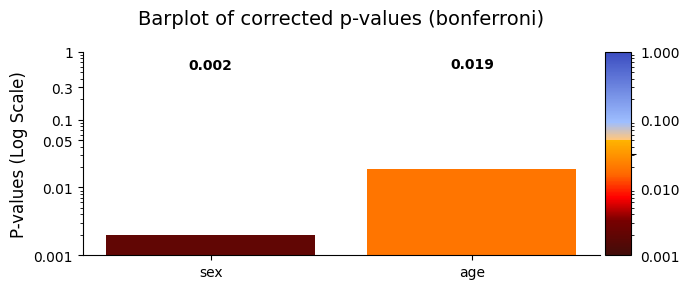

In [12]:
pval_corrected, rejected_corrected =statistics.pval_correction(result_regression["pval"], method='fdr_bh')
# Plot p-values
graphics.plot_p_values_bar(pval_corrected, title_text ="Barplot of corrected p-values (bonferroni)",
                      figsize=(7, 3), alpha=0.05, xticklabels=xticklabels)

**Conclusion - Regression**\
Each p-value corresponds to a specific test of the relationship between ```FO``` and the behavioral variables 'sex' and 'age'.
The permutation test for explained variance shows that there is a significant difference between ```FO``` vs. ```'sex'``` and ```'age'``` after doing to multiple testing.

With respect to ```'sex'```, notable anatomical differences exist between sexes that could influence registration  in  ways that induce differences in the time series, allowing us to find such clear differences.  Similarly, the significant difference in "age" that was found may be explained by changes in brain activity patterns associated with aging or by other physiological reasons. It may also point to possible differences in functional connectivity across different age groups.




### Across subjects - Correlation <a id="perm-correlation"></a>
In correlation analysis, our focus is on unraveling intricate relationships between variables. We can statistically assess the relationships between ```FO``` (R) and the behavioral measurements (D). A significant result suggests that specific probabilities of states in ```FO``` significantly contribute to the observed variations in 'sex and 'age. Conversely, a non-significant result indicates that the observed relationship might be attributed to random chance, and ```FO``` may not significantly influence the variability in 'sex and 'age.

**Run the ```across_subjects``` function**:\
To run the ```across_subjects``` function we just need to provide inputs in the form of D-data (```FO```) and R-data (```data_behavioral```). Sense we take family structure into account we will also include the variable ```dict_fam``` as an input. To export the permutation distribution we set ```test_statistic_option=True```. Additionally, we can account for potential confounding variables by regressing them out through permutation testing.
To initiate correlation-based permutation testing, set ```method="correlation"```.



In [13]:
# Set the parameters for between-subject testing
method = "univariate"
Nperm = 1000 # Number of permutations (default = 0)
test_statistic_option=True
# Perform across-subject testing
result_univariate  =statistics.test_across_subjects(FO, data_behavioral, method=method,Nperm=Nperm,
                                                dict_family=dict_fam,
                                                test_statistics_option=test_statistic_option)


Number of possible permutations is exp(1586.6248450207656).
Generating 1000 shufflings (permutations only).


100%|██████████| 1000/1000 [00:00<00:00, 2206.35it/s]


We can now examine the ```result_univariate``` variable.

In [14]:
result_univariate

{'pval': array([[0.00999001, 0.15184815],
        [0.30769231, 0.48351648],
        [0.26373626, 0.15784216],
        [0.000999  , 0.15784216],
        [0.000999  , 0.42457542],
        [0.002997  , 0.02097902]]),
 'base_statistics': array([[-0.07933842, -0.06140471],
        [ 0.03278736,  0.02328981],
        [ 0.03647573, -0.04466177],
        [ 0.15336239,  0.05553155],
        [-0.13151291, -0.02734073],
        [ 0.0972438 ,  0.08472561]]),
 'test_statistics': array([[[0.07933842, 0.06140471],
         [0.03278736, 0.02328981],
         [0.03647573, 0.04466177],
         [0.15336239, 0.05553155],
         [0.13151291, 0.02734073],
         [0.0972438 , 0.08472561]],
 
        [[0.03983591, 0.07029275],
         [0.02146662, 0.00623377],
         [0.00358085, 0.08382615],
         [0.05520295, 0.02948869],
         [0.04476784, 0.01960782],
         [0.04614773, 0.03412039]],
 
        [[0.05763053, 0.06897893],
         [0.05644884, 0.05281463],
         [0.02016283, 0.00136112],

**Visualization of results**\
Now that we have performed our test, we can then visualize the p-value and correlation matrix.\
We will import the function ```plot_heatmap``` from module ```helperfunctions.py```

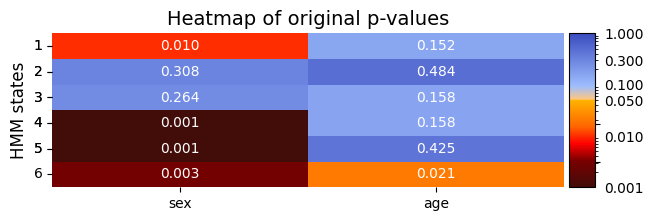

In [15]:
# Plot p-values
alpha=0.05 # p-value threshold
graphics.plot_p_value_matrix(result_univariate["pval"], title_text ="Heatmap of original p-values",
                      figsize=(7, 2), ylabel="HMM states", alpha=alpha, 
                      xticklabels=xticklabels,normalize_vals=True)

**Visualization correlation coefficients (base statistics)**\
Now we can look at the correlation coefficients between the HMM states and the corresponding behavioral parameters "sex" and "age".

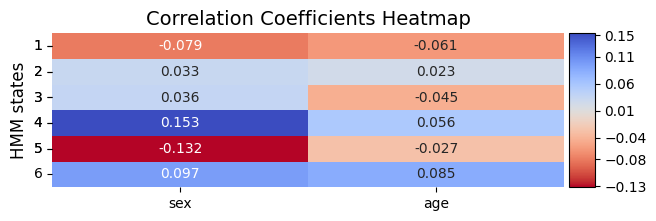

In [16]:
# Plot p-values
alpha=0.05 # p-value threshold
graphics.plot_correlation_matrix(result_univariate["base_statistics"], result_univariate["performed_tests"],
                      figsize=(7, 2), ylabel="HMM states", 
                      xticklabels=xticklabels)

**Multiple Comparison**\
To be sure there is no type 1 error, we can apply the Benjamini/Hochberg to control the False Discovery Rate

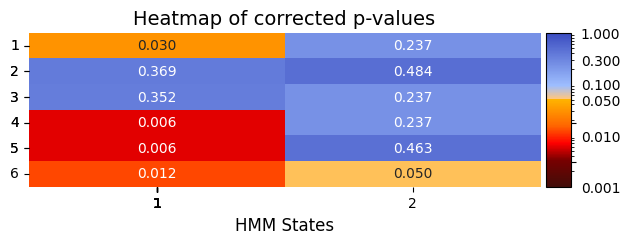

In [17]:
pval_corrected, rejected_corrected =statistics.pval_correction(result_univariate["pval"], method='fdr_bh')
# Plot p-values
graphics.plot_p_value_matrix(pval_corrected, title_text ="Heatmap of corrected p-values",figsize=(7, 2), xlabel="HMM States", ylabel="")

**Plot permutation distribution**\
Presented here are the significant test statistics of our permutation distributionfor the different states.
The red line shows the observed statistic, while the datapoints of the histogram represent the permutation distribution

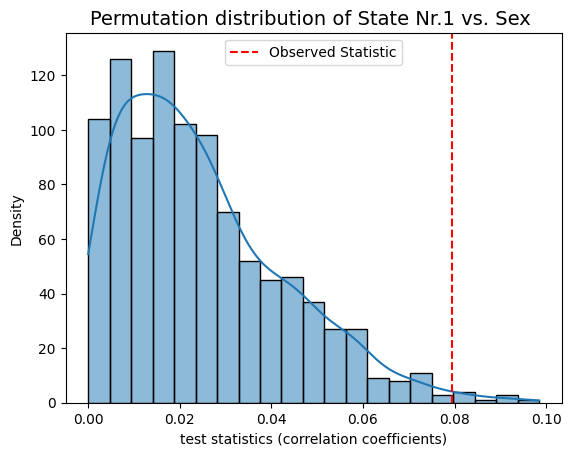

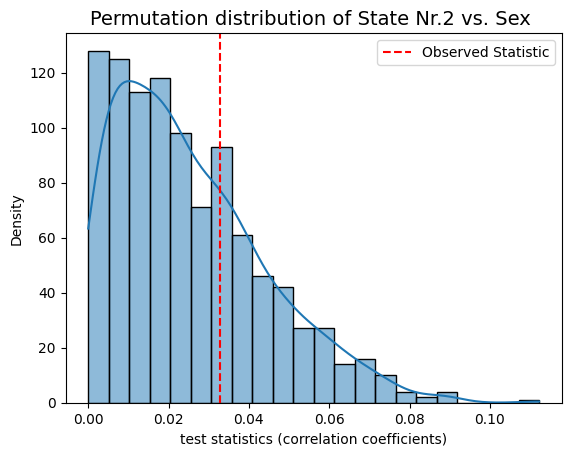

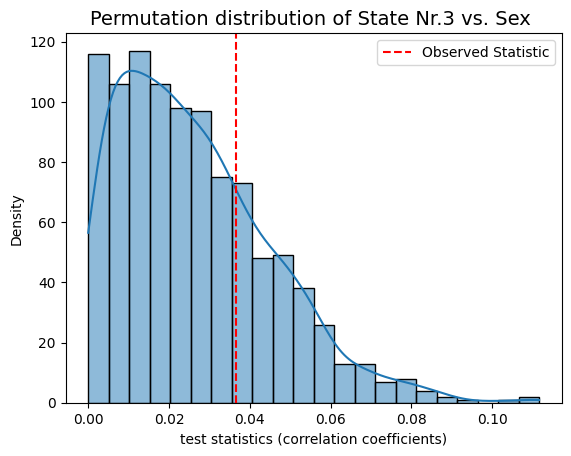

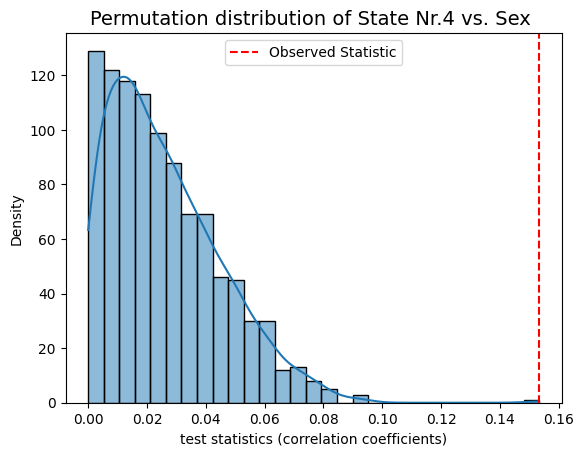

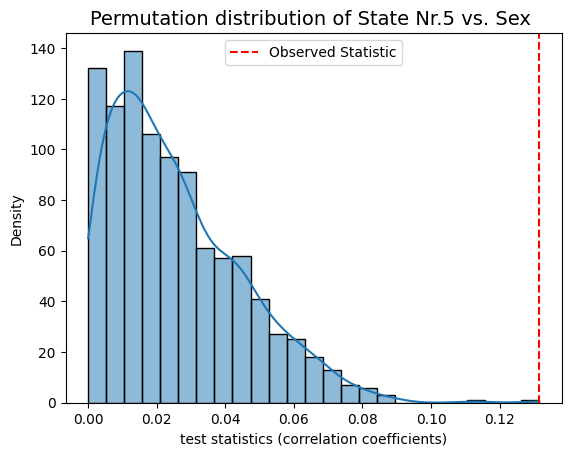

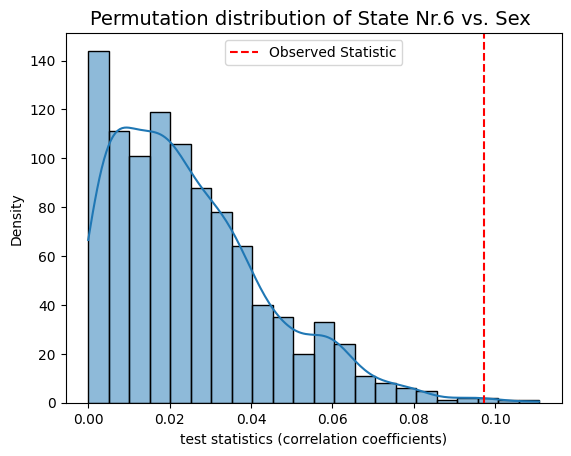

In [18]:
# Plot test statistics for pvals
column_pos =0 # Sex is in column position 0 
xlabel = "test statistics (correlation coefficients)"
#significant_timestamp_position = np.where(pval_corrected< alpha)

# Visualizing the permutation distribution for sex, which got index=0
for i in range(result_univariate["test_statistics"].shape[1]):
    graphics.plot_permutation_distribution(result_univariate["test_statistics"][:,i,column_pos],title_text=f"Permutation distribution of State Nr.{i+1} vs. Sex ", xlabel=xlabel )

### Conclusion - Correlation coefficients
Following permutation testing on correlation across different HMM states derived from ```FO```, the results shows statistically significant correlation for state 1,4,5 and 6 with the behavioral measurements for ```'sex'``` and none for ```'age'```.
With a predetermined alpha value of 0.05, the p-values for these states after multiple comparison show evidence to reject the null hypothesis for these specific HMM state.

What is interesting is that the findings align with the null relationship observed through an alternative prediction approach, which is also part of the GLHMM toolbox. This approach involves predicting age and classifying sex based on all six states' FO, switching rates, and lifetimes ([link](https://github.com/vidaurre/glhmm/blob/main/docs/notebooks/Prediction_example.ipynb)).
